In [10]:
%matplotlib widget
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from simple_pinn import SchrodingersEqDataset, SimplePINN, evalAndCompare, calculateComplexDerivatives, calculateOperator, mse_loss, mseLoss, calculateOperatorLoss, calculateBoundaryLoss
import matplotlib.pyplot as plt

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# load the data
dataset = SchrodingersEqDataset("../PINNs/main/Data/NLS.mat", points_to_sample=10_000)

dl = DataLoader(dataset, batch_size=10_000, shuffle=True)

# create the model
model = SimplePINN(input_size=2, hidden_layers=[100, 100, 100, 100, 100], output_size=2)
model.to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000
for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_f_loss = 0.0
    epoch_init_loss = 0.0
    epoch_bnd_loss = 0.0
    for inputs, _ in dl:
        # calculate the model output on this batch's collocation points
        inputs = inputs.to(device)
        outputs = model(inputs)
        f_loss = calculateOperatorLoss(outputs, inputs)
        # calculate the model output on this batch's initial condition data
        inputs, targets = dataset.getRandomInitSoln(100)
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        init_loss = mseLoss(outputs, targets)
        # calculate the model output on this batch's boundary conditions
        left_inputs, right_inputs = dataset.getRandomBoundaryPoints(100)
        left_inputs, right_inputs = (
            left_inputs.to(device),
            right_inputs.to(device),
        )
        left_outputs = model(left_inputs)
        right_outputs = model(right_inputs)
        bnd_loss = calculateBoundaryLoss(
            left_inputs, left_outputs, right_inputs, right_outputs
        )
        # sum up the losses
        loss = f_loss + init_loss + bnd_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_f_loss += f_loss.item()
        epoch_init_loss += init_loss.item()
        epoch_bnd_loss += bnd_loss.item()
    # print out epoch, loss, init_loss, and f_loss
    epoch_loss /= len(dl)
    epoch_f_loss /= len(dl)
    epoch_init_loss /= len(dl)
    epoch_bnd_loss /= len(dl)
    print(
        f"epoch {epoch}: loss={epoch_loss:.4f}, f_loss={epoch_f_loss:.4f}, init_loss={init_loss:.4f}, bnd_loss={epoch_bnd_loss:.4f}",
    )

cuda
SimplePINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-4): 4 x Linear(in_features=100, out_features=100, bias=True)
  )
  (head): Linear(in_features=100, out_features=2, bias=True)
)
epoch 0: loss=0.6391, f_loss=0.0000, init_loss=0.6375, bnd_loss=0.0016
epoch 1: loss=0.5113, f_loss=0.0000, init_loss=0.5067, bnd_loss=0.0046
epoch 2: loss=0.4458, f_loss=0.0001, init_loss=0.4395, bnd_loss=0.0062
epoch 3: loss=0.3732, f_loss=0.0011, init_loss=0.3708, bnd_loss=0.0013
epoch 4: loss=0.3913, f_loss=0.0075, init_loss=0.3784, bnd_loss=0.0055
epoch 5: loss=0.3001, f_loss=0.0375, init_loss=0.2614, bnd_loss=0.0012
epoch 6: loss=0.3758, f_loss=0.1227, init_loss=0.2527, bnd_loss=0.0005
epoch 7: loss=0.3913, f_loss=0.1383, init_loss=0.2447, bnd_loss=0.0084
epoch 8: loss=0.3299, f_loss=0.0881, init_loss=0.2414, bnd_loss=0.0003
epoch 9: loss=0.3197, f_loss=0.0443, init_loss=0.2739, bnd_loss=0.0015
epoch 10: loss=0.3063, f_loss=0.0213, init_loss

In [12]:
x_grid, t_grid, pred_h, target_h = evalAndCompare(model, dataset)

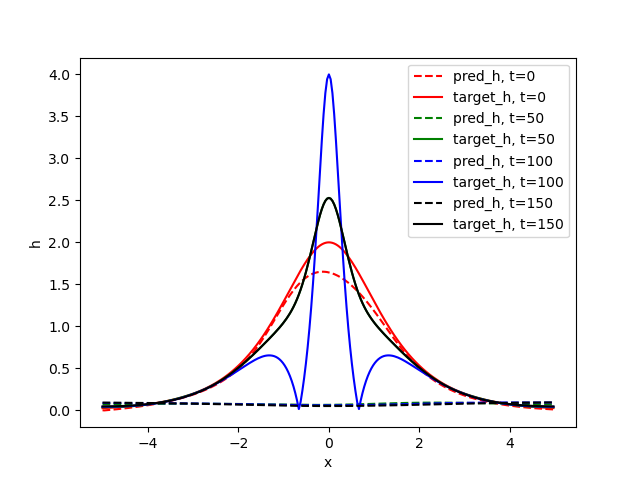

In [13]:
fig = plt.figure()

t_sample = [0, 50, 100, 150]  # Sample values of t
colors = ["r", "g", "b", "k"]  # Colors for each time point
for t_ndx, color in zip(t_sample, colors):
    plt.plot(
        x_grid[:, t_ndx],
        pred_h.detach().numpy()[:, t_ndx],
        linestyle="--",
        label=f"pred_h, t={t_ndx}",
        color=color,
    )
    plt.plot(
        x_grid[:, t_ndx],
        target_h.detach().numpy()[:, t_ndx],
        linestyle="-",
        label=f"target_h, t={t_ndx}",
        color=color,
    )

plt.xlabel("x")
plt.ylabel("h")
plt.legend(loc="best")
plt.show()

In [14]:
(pred_h - target_h)

(torch.Size([256, 201]), torch.Size([256, 201]))